In [1]:
import numpy as np
np.seterr(invalid='ignore')

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

import seaborn as sns

from my_functions import *
from LF_puricomp_corrections import puricomp2d_weights
from load_mocks import *

from scipy.stats import binned_statistic

In [2]:
w_central = central_wavelength()
nb_fwhm_Arr = nb_fwhm(range(60))
w_lya = 1215.67
filter_tags = load_filter_tags()

In [3]:
from minijpas_LF_and_puricomp import load_mocks
pm_flx, pm_err, zspec, EW_lya, L_lya, is_qso, is_sf, is_gal, is_LAE, where_hiL =\
    load_mocks('train', 'minijpas', add_errs=True)

In [4]:
N_sources = pm_flx.shape[1]
N_sources

1116013

In [5]:
mag = flux_to_mag(pm_flx[-2], w_central[-2])
mag[np.isnan(mag)] = 99.

In [6]:
ew0_cut = 30

# Lya search
cont_est_lya, cont_err_lya = estimate_continuum(pm_flx, pm_err, IGM_T_correct=True)
line = is_there_line(pm_flx, pm_err, cont_est_lya, cont_err_lya, ew0_cut)
lya_lines, lya_cont_lines, line_widths = identify_lines(
    line, pm_flx, cont_est_lya, first=True, return_line_width=True
)
lya_lines = np.array(lya_lines)

# Other lines
cont_est_other, cont_err_other = estimate_continuum(pm_flx, pm_err, IGM_T_correct=False)
line_other = is_there_line(pm_flx, pm_err, cont_est_other, cont_err_other,
    100, obs=True)
other_lines = identify_lines(line_other, cont_est_other, pm_err)

# Compute z
z_Arr = np.zeros(N_sources)
z_Arr[np.where(np.array(lya_lines) != -1)] =\
    z_NB(np.array(lya_cont_lines)[np.where(np.array(lya_lines) != -1)])

nice_z = np.abs(z_Arr - zspec) < 0.16

%xdel cont_est_other
%xdel cont_err_other

In [7]:
mag_min = 17
mag_max = 24

nb_min = 5
nb_max = 15
# nb_min = 16
# nb_max = 23

# Used later!!
L_min = 40
L_max = 50

nbs_to_consider = np.arange(nb_min, nb_max + 1)

nb_cut = (np.array(lya_lines) >= nb_min) & (np.array(lya_lines) <= nb_max)

z_min = (w_central[nb_min] - nb_fwhm_Arr[nb_min] * 0.5) / w_lya - 1
z_max = (w_central[nb_max] + nb_fwhm_Arr[nb_max] * 0.5) / w_lya - 1
print(f'z interval: ({z_min:0.2f}, {z_max:0.2f})')

z_cut = (z_min < z_Arr) & (z_Arr < z_max)
zspec_cut = (z_min < zspec) & (zspec < z_max)
ew_cut = EW_lya > ew0_cut
mag_cut = (mag > mag_min) & (mag < mag_max)

nice_lya = nice_lya_select(
    lya_lines, other_lines, pm_flx, pm_err, cont_est_lya, z_Arr
)
nice_lya = (nice_lya & z_cut & mag_cut)

z interval: (2.40, 3.34)


In [27]:
_, _, L_Arr, L_e_Arr, _, _ = EW_L_NB(
    pm_flx, pm_err, cont_est_lya, cont_err_lya, z_Arr, lya_lines, N_nb=0
)

# ML_predict_mask = (mag < 23) & (L_Arr > 0)
# L_Arr[ML_predict_mask] = ML_predict_L(
#     pm_flx[:, ML_predict_mask], pm_err[:, ML_predict_mask],
#     z_Arr[ML_predict_mask], L_Arr[ML_predict_mask], 'RFmag15-23',
#     L_lya[ML_predict_mask]
# )

# ML_predict_mask = (mag > 23) & (mag < 24) & (L_Arr > 0)
# L_Arr[ML_predict_mask] = ML_predict_L(
#     pm_flx[:, ML_predict_mask], pm_err[:, ML_predict_mask],
#     z_Arr[ML_predict_mask], L_Arr[ML_predict_mask], 'RFmag23-23.5',
#     L_lya[ML_predict_mask]
# )

In [28]:
def compute_L_Lbin_err(L_Arr, L_lya, L_binning):
    '''
    Computes the errors due to dispersion of L_retrieved with some L_retrieved binning
    '''
    L_Lbin_err_plus = np.ones(len(L_binning) - 1) * 99
    L_Lbin_err_minus = np.ones(len(L_binning) - 1) * 99
    median = np.ones(len(L_binning) - 1) * 99
    last = [99., 99.]
    for i in range(len(L_binning) - 1):
        in_bin = (10 ** L_Arr >= L_binning[i]) & (10 ** L_Arr < L_binning[i + 1])
        if count_true(in_bin) == 0:
            L_Lbin_err_plus[i] = last[0]
            L_Lbin_err_minus[i] = last[1]
            continue
        perc = np.nanpercentile((L_Arr - L_lya)[in_bin], [16, 50, 84])
        L_Lbin_err_plus[i] = perc[2] - perc[1]
        
        last = [L_Lbin_err_plus[i], L_Lbin_err_minus[i]]
        median[i] = 10 ** perc[1]

    return L_Lbin_err_plus, median

L_binning = np.logspace(41, 46, 20 + 1)
L_bin_c = [L_binning[i : i + 1].sum() * 0.5 for i in range(len(L_binning) - 1)]
L_Lbin_err, median_L = compute_L_Lbin_err(
    L_Arr[nice_lya & nice_z], L_lya[nice_z & nice_lya], L_binning
)
np.save('npy/L_nb_err.npy', L_Lbin_err)
np.save('npy/L_bias.npy', median_L)
np.save('npy/L_nb_err_binning.npy', L_binning)

In [29]:
# Correct L_Arr with the median
L_Arr =  np.log10(10 ** L_Arr - np.interp(10 ** L_Arr, L_bin_c, median_L))

In [30]:
# Apply bin err
L_binning_position = binned_statistic(
        10 ** L_Arr, None, 'count', bins=L_binning
).binnumber
L_binning_position[L_binning_position > len(L_binning) - 2] = len(L_binning) - 2
L_e_Arr = L_Lbin_err[L_binning_position]

In [31]:
# %xdel pm_flx
# %xdel pm_err
# %xdel cont_est_lya
# %xdel cont_err_lya

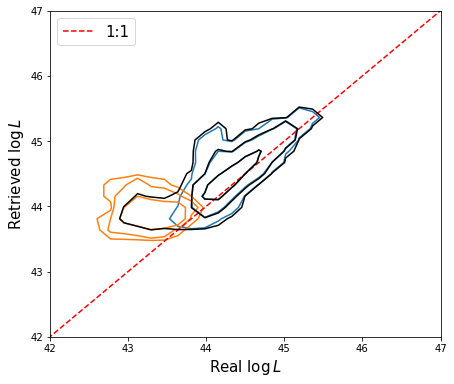

In [32]:
def plot_contours(is_qso, maskk):
    fig, ax = plt.subplots(figsize=(7, 6))

    mask = (nice_lya & nice_z & maskk)
    Z, x, y = np.histogram2d(
        L_lya[mask], L_Arr[mask],
        bins=(np.linspace(42, 47, 30), np.linspace(42, 47, 30))
    )

    H_min = np.amin(Z)
    H_max = np.amax(Z)

    y_centers = 0.5 * ( y[1:] + y[:-1] )
    x_centers = 0.5 * ( x[1:] + x[:-1] )

    N_bins = 10000

    H_Arr = np.linspace(H_min , H_max , N_bins)[::-1]

    fact_up_Arr = np.zeros( N_bins )

    TOTAL_H = np.sum(Z)

    for iii in range(0, N_bins):

        mask = Z > H_Arr[iii]

        fact_up_Arr[iii] = np.sum(Z[ mask ]) / TOTAL_H

    H_value_68 = np.interp(0.683, fact_up_Arr, H_Arr) # 1sigma
    H_value_95 = np.interp(0.954, fact_up_Arr, H_Arr) # 2sigma
    H_value_99 = np.interp(0.997, fact_up_Arr, H_Arr) # 2sigma

    ax.contour(
        x_centers, y_centers, Z.T, levels=[H_value_99, H_value_95, H_value_68],
        colors='k', zorder=99
    )

    mask = ((mag[is_qso] < 24) & nice_lya[is_qso] & nice_z[is_qso] & maskk[is_qso])
    Z, x, y = np.histogram2d(
        L_lya[is_qso][mask], L_Arr[is_qso][mask],
        bins=(np.linspace(42, 47, 30), np.linspace(42, 47, 30))
    )

    H_min = np.amin(Z)
    H_max = np.amax(Z)

    y_centers = 0.5 * ( y[1:] + y[:-1] )
    x_centers = 0.5 * ( x[1:] + x[:-1] )

    N_bins = 10000

    H_Arr = np.linspace(H_min , H_max , N_bins)[::-1]

    fact_up_Arr = np.zeros( N_bins )

    TOTAL_H = np.sum(Z)

    for iii in range(0, N_bins):

        mask = Z > H_Arr[iii]

        fact_up_Arr[iii] = np.sum(Z[ mask ]) / TOTAL_H

    H_value_68 = np.interp(0.683, fact_up_Arr, H_Arr) # 1sigma
    H_value_95 = np.interp(0.954, fact_up_Arr, H_Arr) # 2sigma
    H_value_99 = np.interp(0.997, fact_up_Arr, H_Arr) # 2sigma

    ax.contour(
        x_centers, y_centers, Z.T, levels=[H_value_99, H_value_95, H_value_68],
        colors='C0'
    )

    mask = (is_sf & nice_lya & nice_z & maskk)
    Z, x, y = np.histogram2d(
        L_lya[mask], L_Arr[mask],
        bins=(np.linspace(42, 47, 30), np.linspace(42, 47, 30))
    )

    H_min = np.amin(Z)
    H_max = np.amax(Z)

    y_centers = 0.5 * ( y[1:] + y[:-1] )
    x_centers = 0.5 * ( x[1:] + x[:-1] )

    N_bins = 10000

    H_Arr = np.linspace(H_min , H_max , N_bins )[::-1]

    fact_up_Arr = np.zeros(N_bins)

    TOTAL_H = np.sum(Z)

    for iii in range(0, N_bins):

        mask = Z > H_Arr[iii]

        fact_up_Arr[iii] = np.sum(Z[ mask ]) / TOTAL_H

    H_value_68 = np.interp(0.683, fact_up_Arr, H_Arr) # 1sigma
    H_value_95 = np.interp(0.954, fact_up_Arr, H_Arr) # 2sigma
    H_value_99 = np.interp(0.997, fact_up_Arr, H_Arr) # 2sigma

    ax.contour(
        x_centers, y_centers, Z.T, levels=[H_value_99, H_value_95, H_value_68],
        colors='C1'
    )

    # ax.clabel(CS, inline=1, fontsize=10)

    # ax.scatter(L_lya[nice_lya & is_qso], L_Arr[nice_lya & is_qso],
    #     label='QSO', alpha=0.3)
    # ax.scatter(L_lya[nice_lya & is_sf], L_Arr[nice_lya & is_sf],
    #     label='SF', alpha=0.3)

    x = np.linspace(40, 48, 100)
    ax.plot(x, x, linestyle='--', color='red', label='1:1')

    # Lx = [(L_binning[i] + L_binning[i + 1]) / 2 for i in range(len(L_binning) - 1)]
    # ax.plot(Lx, Lx + median_L, c='k')
    # ax.plot(Lx, Lx + median_L - L_Lbin_err[1], c='gray')
    # ax.plot(Lx, Lx + median_L + L_Lbin_err[0], c='gray')

    ax.set_ylabel('Retrieved $\log L$', fontsize=15)
    ax.set_xlabel('Real $\log L$', fontsize=15)

    ax.set_ylim((42, 47))
    ax.set_xlim((42, 47))

    ax.legend(fontsize=15)

    plt.show()

mmin = 17
mmax = 23
maskk = (mag > mmin) & (mag < mmax)
plot_contours(is_qso, maskk)

In [15]:
gal_area = 5.54
bad_qso_area = 200
sf_area = 200
good_qso_area = 400
hiL_qso_area = 4000

# The proportional factors are made in relation to bad_qso
# So bad_qso_factor = 1
gal_factor = bad_qso_area / gal_area
good_qso_factor = bad_qso_area / good_qso_area
hiL_factor = bad_qso_area / hiL_qso_area

23.420250000000003


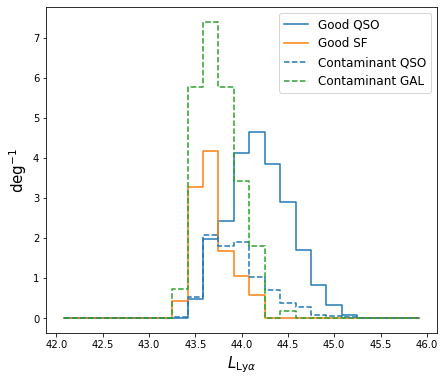

In [16]:
def do_this(mmin, mmax):
    nice = (nice_lya & nice_z) & (mag > mmin) & (mag < mmax)
    not_nice = (nice_lya & ~nice_z)
    z_cut = (z_Arr > z_min) & (z_Arr < z_max)

    good_qso_loL = L_Arr[z_cut & nice & is_qso & ~where_hiL]
    good_qso_hiL = L_Arr[z_cut & nice & is_qso & where_hiL]
    good_sf = L_Arr[z_cut & nice & is_sf]

    bad_qso = L_Arr[z_cut & not_nice & ~is_LAE]
    bad_qso_LAE_loL = L_Arr[z_cut & not_nice & is_qso & is_LAE & ~where_hiL]
    bad_qso_LAE_hiL = L_Arr[z_cut & not_nice & is_qso & is_LAE & where_hiL]
    bad_sf = L_Arr[z_cut & not_nice & is_sf]
    bad_gal = L_Arr[z_cut & nice_lya & is_gal & (zspec < 1.9)]

    bins = np.linspace(42, 46, 25)
    bin_c = [bins[i : i + 2].sum() * 0.5 for i in range(len(bins) - 1)]

    # All histograms are made for 1deg2

    h_good_qso_loL = np.histogram(good_qso_loL, bins)[0] / good_qso_area
    h_good_qso_hiL = np.histogram(good_qso_hiL, bins)[0] / hiL_qso_area
    h_good_sf = np.histogram(good_sf, bins)[0] / sf_area
    h_bad_qso = np.histogram(bad_qso, bins)[0] / bad_qso_area
    h_bad_qso_LAE_loL = np.histogram(bad_qso_LAE_loL, bins)[0] / good_qso_area
    h_bad_qso_LAE_hiL = np.histogram(bad_qso_LAE_hiL, bins)[0] / hiL_qso_area
    h_bad_sf = np.histogram(bad_sf, bins)[0] / sf_area
    h_bad_gal = np.histogram(bad_gal, bins)[0] / gal_area

    h_good_qso = h_good_qso_loL + h_good_qso_hiL
    h_bad_qso = h_bad_qso + h_bad_qso_LAE_hiL + h_bad_qso_LAE_loL

    print(h_good_qso.sum())

    fig, ax = plt.subplots(figsize=(7, 6))

    ax.plot(bin_c, h_good_qso,
            color='C0', drawstyle='steps', label='Good QSO')
    ax.plot(bin_c, h_good_sf,
            color='C1', drawstyle='steps', label='Good SF')
    ax.plot(bin_c, h_bad_qso,
            color='C0', drawstyle='steps', ls='--', label='Contaminant QSO')
    # ax.plot(bin_c, h_bad_sf,
    #         color='C1', drawstyle='steps', ls='--', label='Bad SF')
    ax.plot(bin_c, h_bad_gal,
            color='C2', drawstyle='steps', ls='--', label='Contaminant GAL')

#     ax.set_ylim(1, 10)
#     ax.set_yscale('log')
    ax.set_ylabel('deg$^{-1}$', fontsize=15)
    ax.set_xlabel(r'$L_{\mathrm{Ly}\alpha}$', fontsize=15)

    ax.legend(fontsize=12)

    plt.show()

do_this(15, 24)

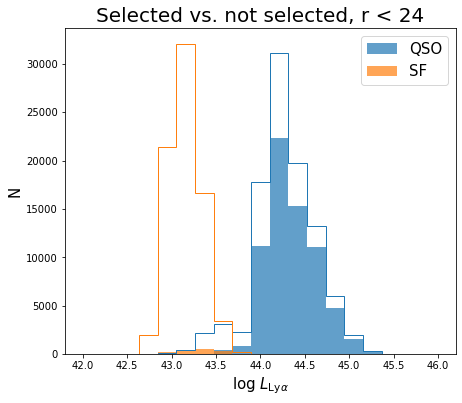

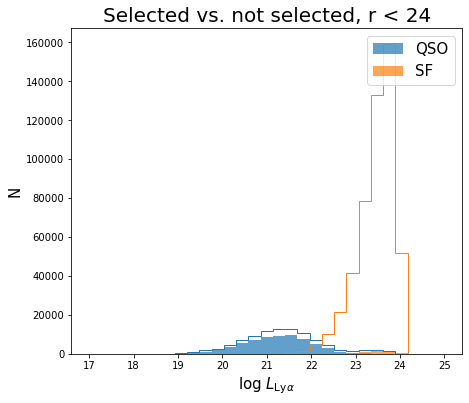

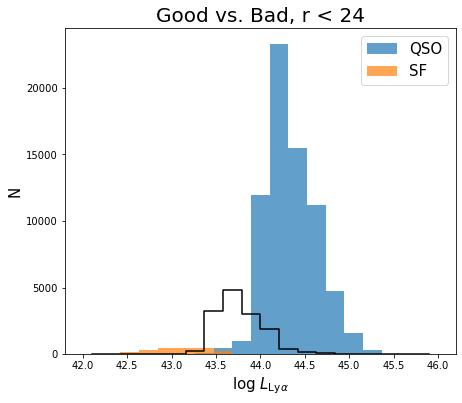

In [17]:
def do_this():
    mag_max = 24

    fig, ax = plt.subplots(figsize=(7, 6))

    mask = ((mag < mag_max) & is_qso & zspec_cut & ew_cut)
    ax.hist(
        L_lya[mask & nice_lya], bins=np.linspace(42, 46, 20),
        color='C0', label='QSO', alpha=0.7
    )
    ax.hist(L_lya[mask], bins=np.linspace(42, 46, 20), color='C0', histtype='step')

    mask = ((mag < mag_max) & is_sf & ew_cut)
    ax.hist(
        L_lya[mask & nice_lya], bins=np.linspace(42, 46, 20),
        color='C1', label='SF', alpha=0.7
    )
    ax.hist(L_lya[mask], bins=np.linspace(42, 46, 20), color='C1', histtype='step')

    mask = (nice_lya & (mag < mag_max) & ~is_qso & ~is_sf)

    ax.legend(fontsize=15)

    ax.set_xlabel(r'log $L_{\mathrm{Ly}\alpha}$', fontsize=15)
    ax.set_ylabel('N', fontsize=15)
    ax.set_title(f'Selected vs. not selected, r < {mag_max}', fontsize=20)

    plt.show()
    
    fig, ax = plt.subplots(figsize=(7, 6))

    bins = np.linspace(17, 25, 30)
    mask = ((mag < mag_max) & is_qso & zspec_cut & ew_cut)
    ax.hist(
        mag[mask & nice_lya], bins=bins,
        color='C0', label='QSO', alpha=0.7
    )
    ax.hist(mag[mask], bins=bins, color='C0', histtype='step')

    mask = ((mag < mag_max) & is_sf)
    ax.hist(
        mag[mask & nice_lya], bins=bins,
        color='C1', label='SF', alpha=0.7
    )
    ax.hist(mag[mask], bins=bins, color='C1', histtype='step')

    mask = (nice_lya & (mag < mag_max) & ~is_qso & ~is_sf)

    ax.legend(fontsize=15)

    ax.set_xlabel(r'log $L_{\mathrm{Ly}\alpha}$', fontsize=15)
    ax.set_ylabel('N', fontsize=15)
    ax.set_title(f'Selected vs. not selected, r < {mag_max}', fontsize=20)

    plt.show()

    fig, ax = plt.subplots(figsize=(7, 6))

    bins = np.linspace(42, 46, 20)
    mask = ((mag < mag_max))
    ax.hist(
        L_lya[mask & nice_lya & nice_z & is_qso], bins=bins,
        color='C0', label='QSO', alpha=0.7
    )
    ax.hist(
        L_lya[mask & nice_lya & nice_z & is_sf], bins=bins,
        color='C1', label='SF', alpha=0.7
    )
    h_gal, b = np.histogram(
        L_Arr[mask & nice_lya & is_gal],
        bins=bins
    )
    h_con, b = np.histogram(
        L_Arr[mask & nice_lya & ~is_gal & ~nice_z],
        bins=bins
    )
    bc = [(b[i] + b[i + 1]) * 0.5 for i in range(len(b) - 1)]
    
    ax.step(bc, h_con + h_gal * gal_factor, color='k')

    ax.legend(fontsize=15)

    ax.set_xlabel(r'log $L_{\mathrm{Ly}\alpha}$', fontsize=15)
    ax.set_ylabel('N', fontsize=15)
    ax.set_title(f'Good vs. Bad, r < {mag_max}', fontsize=20)

    plt.show()
do_this()

In [18]:
bins = np.log10(L_binning)
bin_centers = [(bins[k] + bins[k + 1]) / 2 for k in range(len(bins) - 1)]

phistar1 = 3.33e-6
Lstar1 = 10 ** 44.65
alpha1 = -1.35
phistar2 = 10 ** -3.45
Lstar2 = 10 ** 42.93
alpha2 = -1.93

volume = z_volume(z_min, z_max, 200)

bins2 = np.linspace(43, 45.5, 10)
# h_qso, _ = np.histogram(L_lya[is_qso & zspec_cut & ew_cut & mag_cut], bins2)
# h_sf, _ = np.histogram(L_lya[is_sf & zspec_cut & ew_cut & mag_cut], bins2)

b_c = [0.5 * (bins2[i] + bins2[i + 1]) for i in range(len(bins2) - 1)]
bw = [bins2[i + 1] - bins2[i] for i in range(len(bins2) - 1)]
###################################################

# fig, ax = plt.subplots(figsize=(7, 6))

# totals_mask = zspec_cut & mag_cut & ew_cut

# goodh = L_lya[nice_lya & nice_z & totals_mask]
# badh = L_Arr[nice_lya & ~nice_z & (is_qso | is_sf)]
# badh_gal = L_Arr[nice_lya & ~nice_z & is_gal]

# hg, bg = np.histogram(goodh, bins=bins2)
# hb, _ = np.histogram(badh, bins=bins2)
# hb_gal, _ = np.histogram(badh_gal, bins=bins2)
# hb_gal = hb_gal * gal_factor
# totals, _ = np.histogram(L_lya[totals_mask], bins=bins2)

# # Cumulative completeness/purity
# # hg = np.cumsum(hg[::-1])[::-1]
# # hb = np.cumsum(hb[::-1])[::-1]
# # hb_gal = np.cumsum(hb_gal[::-1])[::-1]
# # totals = np.cumsum(totals[::-1])[::-1]

# ax.plot(b_c, hg / totals, marker='^', label='Completeness', zorder=99)
# ax.plot(b_c, hg / (hg + hb + hb_gal), marker='s', label='Purity', zorder=99)

# ax.set_xlabel('$\log L$', fontsize=15)

# ax.set_xlim((42, 46))
# ax.set_ylim((0, 1))
# ax.legend(fontsize=15)
# ax.set_title('Total', fontsize=20)

# plt.show()

# fig, ax = plt.subplots(figsize=(7, 6))

# goodh = L_lya[nice_lya & nice_z & is_qso]
# badh = L_lya[nice_lya & ~nice_z & is_qso]
# hg, bg = np.histogram(goodh, bins=bins)
# hb, _ = np.histogram(badh, bins=bins)
# totals, _ = np.histogram(L_lya[zspec_cut & is_qso], bins=bins)

# ax.plot(b_c, hg / totals, marker='^', label='Completeness', zorder=99)
# ax.plot(b_c, hg / (hg + hb), marker='s', label='Purity', zorder=99)

# ax.set_xlabel('$\log L$', fontsize=15)

# ax.set_xlim((42, 45.5))
# ax.set_ylim((0, 1))
# ax.legend(fontsize=15)
# ax.set_title('QSO', fontsize=20)

# plt.show()

# fig, ax = plt.subplots(figsize=(7, 6))

# goodh = L_lya[nice_lya & nice_z & is_sf]
# badh = L_lya[nice_lya & ~nice_z & is_sf]
# hg, bg = np.histogram(goodh, bins=bins)
# hb, _ = np.histogram(badh, bins=bins)
# totals, _ = np.histogram(L_lya[zspec_cut & is_sf], bins=bins)

# ax.plot(b_c, hg / totals, marker='^', label='Completeness', zorder=99)
# ax.plot(b_c, hg / (hg + hb), marker='s', label='Purity', zorder=99)

# ax.set_xlabel('$\log L$', fontsize=15)

# ax.set_xlim((42, 45.5))
# ax.set_ylim((0, 1))
# ax.legend(fontsize=15)
# ax.set_title('SF', fontsize=20)

# plt.show()

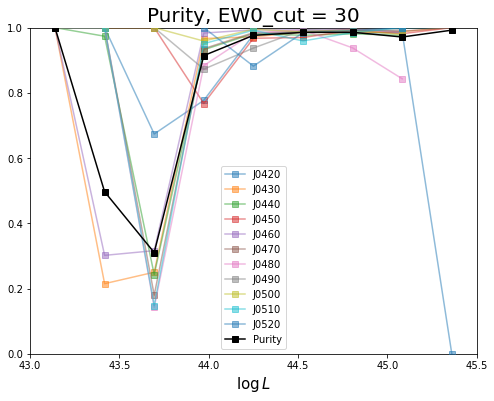

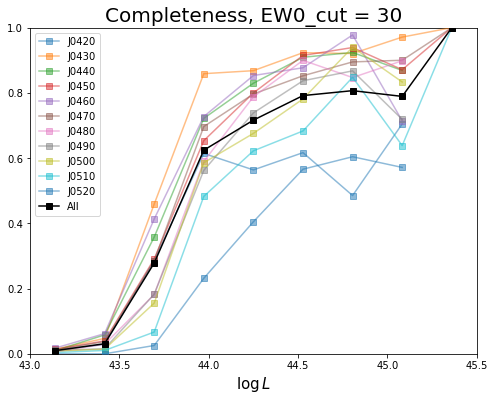

In [19]:
def do_this(which_one):
    fig, ax = plt.subplots(figsize=(8, 6))

    this_mag_cut = (mag < 23)

    for nb in nbs_to_consider:
        nb_mask = (lya_lines == nb)

        z_min = (w_central[nb] - nb_fwhm_Arr[nb] * 0.5) / w_lya - 1
        z_max = (w_central[nb] + nb_fwhm_Arr[nb] * 0.5) / w_lya - 1

        this_zspec_cut = (z_min < zspec) & (zspec < z_max)
        this_z_cut = (z_min < z_Arr) & (z_Arr < z_max)
        totals_mask = this_zspec_cut & this_mag_cut

        goodh = L_lya[nice_lya & nice_z & this_z_cut & totals_mask]
        goodh_comp = L_lya[nice_lya & nice_z & totals_mask]
        badh = L_Arr[nice_lya & ~nice_z & (is_qso | is_sf) & nb_mask & this_mag_cut]
        badh_gal = L_Arr[nice_lya & ~nice_z & is_gal & nb_mask & this_mag_cut]

        hg, bg = np.histogram(goodh, bins=bins2)
        hg_comp, _ = np.histogram(goodh_comp, bins=bins2)
        hb, _ = np.histogram(badh, bins=bins2)
        hb_gal, _ = np.histogram(badh_gal, bins=bins2)
        hb_gal = hb_gal * gal_factor
        totals, _ = np.histogram(L_lya[totals_mask], bins=bins2)

        if which_one == 'Completeness':
            ax.plot(b_c, hg_comp / totals, marker='s', label=filter_tags[nb], zorder=99, alpha=0.5)
        if which_one == 'Purity':
            ax.plot(b_c, hg / (hg + hb + hb_gal), marker='s', label=filter_tags[nb], zorder=99, alpha=0.5)

    nb_min = nbs_to_consider[0]
    nb_max = nbs_to_consider[-1]
    nb_mask = (lya_lines >= nb_min) & (lya_lines <= nb_max)
    z_min = (w_central[nb_min] - nb_fwhm_Arr[nb_min] * 0.5) / w_lya - 1
    z_max = (w_central[nb_max] + nb_fwhm_Arr[nb_max] * 0.5) / w_lya - 1
    this_zspec_cut = (z_min < zspec) & (zspec < z_max)

    totals_mask = this_zspec_cut & this_mag_cut

    goodh = L_lya[nice_lya & nice_z & totals_mask & nb_mask]
    goodh_comp = L_lya[nice_lya & nice_z & totals_mask]
    badh = L_Arr[nice_lya & ~nice_z & (is_qso | is_sf) & this_mag_cut & nb_mask]
    badh_gal = L_Arr[nice_lya & ~nice_z & is_gal & this_mag_cut & nb_mask]

    hg, _ = np.histogram(goodh, bins=bins2)
    hg_comp, _ = np.histogram(goodh_comp, bins=bins2)
    hb, _ = np.histogram(badh, bins=bins2)
    hb_gal, _ = np.histogram(badh_gal, bins=bins2)
    hb_gal = hb_gal * gal_factor
    totals, _ = np.histogram(L_lya[totals_mask], bins=bins2)

    if which_one == 'Completeness':
        ax.plot(b_c, hg_comp / totals, marker='s', label='All', zorder=99, c='k')
    if which_one == 'Purity':
        ax.plot(b_c, hg / (hg + hb + hb_gal), marker='s', label='Purity', zorder=99, c='k')

    ax.set_xlabel('$\log L$', fontsize=15)

    ax.set_xlim((43, 45.5))
    ax.set_ylim((0, 1))
    ax.legend()
    ax.set_title(f'{which_one}, EW0_cut = {ew0_cut}', fontsize=20)

    plt.show()

do_this('Purity')
do_this('Completeness')

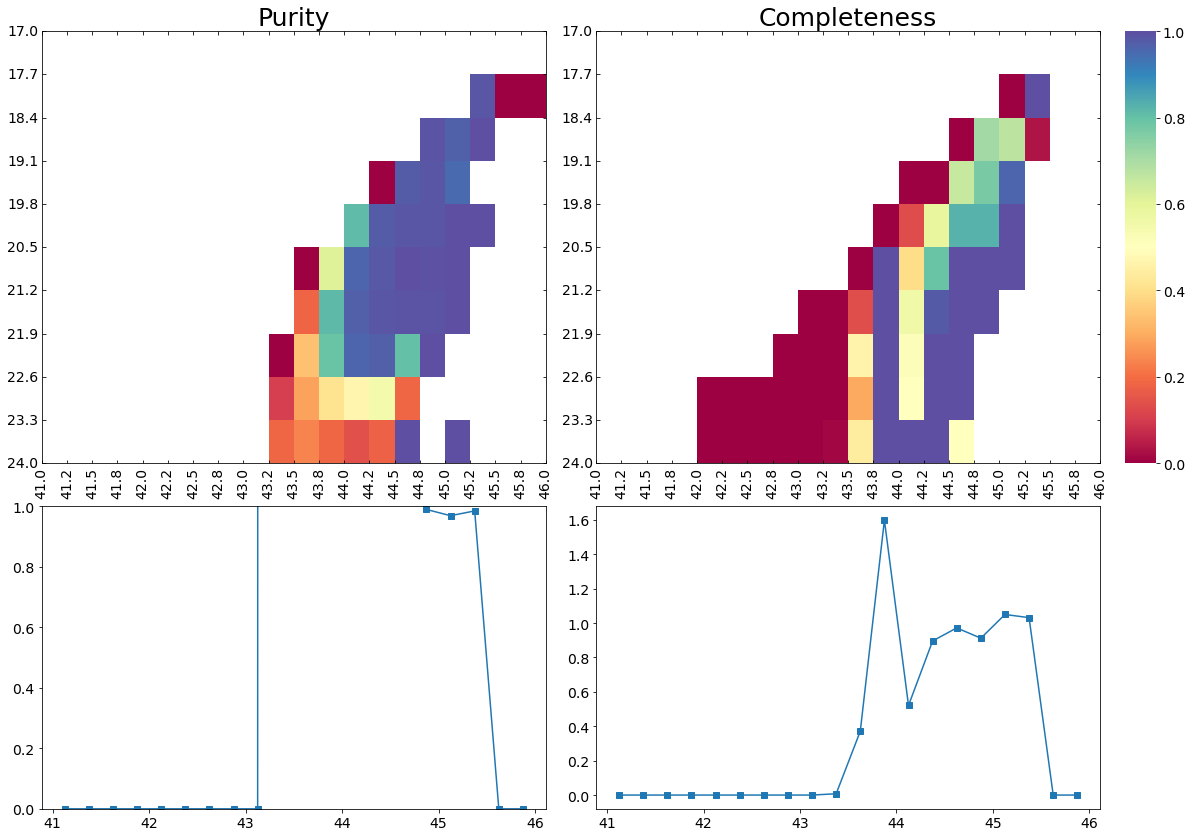

In [20]:
def make_2d_puricomp(L_Arr, L_lya, mag, L_bins):
    fig = plt.figure(figsize=(7, 6))

    height = 1.
    width = 1.
    height2 = 0.7
    spacing = 0.1
    cbar_width = 0.06

    ax0 = fig.add_axes([0, height2 + spacing, width, height])
    ax1 = fig.add_axes([width + spacing, height2 + spacing, width, height])
    axc = fig.add_axes([2 * width + 1.5 * spacing, height2 + spacing, cbar_width, height])
    ax2 = fig.add_axes([0, 0, width, height2])
    ax3 = fig.add_axes([width + spacing, 0, width, height2])

    r_bins = np.linspace(mag_min, mag_max, 10 + 1)

    L_bins_c = np.array([0.5 * (L_bins[i] + L_bins[i + 1]) for i in range(len(L_bins) - 1)])

    # Perturb L
    N_iter = 1000
    h2d_nice_i = np.empty((len(L_bins) - 1, len(r_bins) - 1, N_iter))
    h2d_sel_i = np.empty((len(L_bins) - 1, len(r_bins) - 1, N_iter))
    h2d_sel_gal_i = np.empty((len(L_bins) - 1, len(r_bins) - 1, N_iter))
    h1d_nice_i = np.empty((len(L_bins) - 1, N_iter))
    h1d_sel_i = np.empty((len(L_bins) - 1, N_iter))
    h1d_sel_gal_i = np.empty((len(L_bins) - 1, N_iter))

    for k in range(N_iter):
        L_perturbed = np.log10(
            10 ** L_Arr + L_e_Arr * np.random.randn(len(L_e_Arr))
        )
        L_perturbed[np.isnan(L_perturbed)] = 0.

        h2d_nice_i[..., k], _, _ = np.histogram2d(
            L_perturbed[nice_lya & nice_z],
            mag[nice_lya & nice_z],
            bins=[L_bins, r_bins]
        )

        h2d_sel_i[..., k], _, _ = np.histogram2d(
            L_perturbed[nice_lya & ~is_gal],
            mag[nice_lya & ~is_gal],
            bins=[L_bins, r_bins]
        )

        h2d_sel_gal_i[..., k], _, _ = np.histogram2d(
            L_perturbed[nice_lya & is_gal],
            mag[nice_lya & is_gal],
            bins=[L_bins, r_bins]
        )

        h1d_nice_i[..., k], _ = np.histogram(L_perturbed[nice_lya & nice_z], bins=L_bins)
        h1d_sel_i[..., k], _ = np.histogram(L_perturbed[nice_lya & ~is_gal], bins=L_bins)
        h1d_sel_gal_i[..., k], _ = np.histogram(L_perturbed[nice_lya & is_gal], bins=L_bins)

    # Take the median
    h2d_nice = np.median(h2d_nice_i, axis=2)
    h2d_sel = np.median(h2d_sel_i, axis=2)
    h2d_sel_gal = np.median(h2d_sel_gal_i, axis=2)
    h1d_nice = np.median(h1d_nice_i, axis=1)
    h1d_sel = np.median(h1d_sel_i, axis=1)
    h1d_sel_gal = np.median(h1d_sel_gal_i, axis=1)

    h2d_parent, _, _ = np.histogram2d(
        L_lya[zspec_cut & mag_cut & ew_cut],
        mag[zspec_cut & mag_cut & ew_cut],
        bins=[L_bins, r_bins]
    )
    h1d_parent, _ = np.histogram(L_lya[zspec_cut & mag_cut & ew_cut], bins=L_bins)

    cmap = 'Spectral'

    puri2d = h2d_nice / (h2d_sel + h2d_sel_gal * gal_factor)
    comp2d = h2d_nice / h2d_parent
    puri1d = h1d_nice / h1d_sel + h1d_sel_gal * gal_factor
    comp1d = h1d_nice / h1d_parent

    puri1d[np.isnan(puri1d)] = 0.
    comp1d[np.isnan(comp1d)] = 0.

    ### PLOT STUFF

    sns.heatmap(puri2d.T, ax=ax0, vmin=0, vmax=1, cbar_ax=axc, cmap=cmap)
    sns.heatmap(comp2d.T, ax=ax1, vmin=0, vmax=1, cbar=False, cmap=cmap)

    ax2.plot(L_bins_c, puri1d, marker='s')
    ax3.plot(L_bins_c, comp1d, marker='s')

    ### TICKS

    xticks = range(len(L_bins))
    yticks = range(len(r_bins))
    xtick_labels = ['{0:0.1f}'.format(n) for n in L_bins]
    ytick_labels = ['{0:0.1f}'.format(n) for n in r_bins]


    ax0.set_yticks(yticks)
    ax0.set_yticklabels(ytick_labels, rotation='horizontal')
    ax0.set_xticks(xticks)
    ax0.set_xticklabels(xtick_labels, rotation='vertical')
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(axis='y', direction='in', labelsize=14)
    ax0.tick_params(axis='x', direction='in', labelsize=14)

    ax1.set_yticks(yticks)
    ax1.set_yticklabels(ytick_labels, rotation='horizontal')
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xtick_labels, rotation='vertical')
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.tick_params(axis='y', direction='in', labelsize=14)
    ax1.tick_params(axis='x', direction='in', labelsize=14)

    axc.tick_params(labelsize=14)
    ax2.tick_params(labelsize=14)
    ax3.tick_params(labelsize=14)

    ## Spines
    ax0.spines[:].set_visible(True)
    ax1.spines[:].set_visible(True)

    ## Axes labels
    # ax0.set_ylabel('rSDSS')
    # ax0.set_xlabel('log L$_\mathrm{Lya}$')
    # ax1.set_ylabel('rSDSS')
    # ax1.set_xlabel('log L$_\mathrm{Lya}$')

    ## Axis lims
    ax2.set_ylim((0, 1))
    # ax3.set_ylim((0, 1))

    ## Titles
    ax0.set_title('Purity', fontsize=25)
    ax1.set_title('Completeness', fontsize=25)

    plt.show()

    # np.save('npy/puri2d.npy', puri2d)
    # np.save('npy/comp2d.npy', comp2d)
    # np.save('npy/puricomp2d_L_bins.npy', L_bins)
    # np.save('npy/puricomp2d_r_bins.npy', r_bins)

    return puri2d, comp2d, L_bins, r_bins
puri2d, comp2d, L_bins, r_bins = make_2d_puricomp(L_Arr, L_lya, mag, bins)

In [21]:
def LF_perturb_err(L_Arr, L_e_Arr, nice_lya, bins):
    N_bins = len(bins) - 1

    N_iter = 500

    hist_i_mat = np.zeros((N_iter, N_bins))

    for k in range(N_iter):
        L_perturbed = np.log10(
            10 ** L_Arr + L_e_Arr * np.random.randn(len(L_e_Arr))
        )
        L_perturbed[np.isnan(L_perturbed)] = 0.

        w, puri, comp = puricomp2d_weights(
            L_perturbed[nice_lya], mag[nice_lya], puri2d, comp2d, None, None,
            L_bins, r_bins, True
        )
        w = np.random.rand(len(puri))
        include_mask = (w < puri)
        w[:] = 1.
        w[~include_mask] = 0.
        w[include_mask] = 1. / comp[include_mask]
        w[np.isnan(w) | np.isinf(w)] = 0.

        h, _ = np.histogram(L_perturbed[nice_lya], bins=bins, weights=w)

        hist_i_mat[k] = h

    L_LF_err_percentiles = np.percentile(hist_i_mat, [16, 50, 84], axis=0)
    return L_LF_err_percentiles

L_LF_err_percentiles = LF_perturb_err(L_Arr, L_e_Arr, nice_lya, bins)
L_LF_err_plus = L_LF_err_percentiles[2] - L_LF_err_percentiles[1]
L_LF_err_minus = L_LF_err_percentiles[1] - L_LF_err_percentiles[0]
hist_median = L_LF_err_percentiles[1]

TypeError: puricomp2d_weights() takes from 6 to 7 positional arguments but 9 were given

In [ ]:
LF_bins = np.array([(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)])

bin_width = np.array([bins[i + 1] - bins[i] for i in range(len(bins) - 1)])

volume = z_volume(z_min, z_max, 200)

yerr_cor_plus = (hist_median + L_LF_err_plus ** 2) ** 0.5\
     / volume / bin_width
yerr_cor_minus = (hist_median + L_LF_err_minus ** 2) ** 0.5\
     / volume / bin_width

fig, ax = plt.subplots(figsize=(10, 7))

yerr_cor_plus = (hist_median + L_LF_err_plus ** 2) ** 0.5\
     / volume / bin_width
yerr_cor_minus = (hist_median + L_LF_err_minus ** 2) ** 0.5\
     / volume / bin_width
xerr = bin_width / 2
ax.errorbar(LF_bins, hist_median / volume / bin_width,
    yerr= [yerr_cor_minus, yerr_cor_plus], xerr=xerr,
    marker='.', linestyle='', markersize=15, c='red',
    label='Corrected median histogram')

bins2 = np.linspace(42, 46, 30)
b_c = [(bins2[i] + bins2[i + 1]) * 0.5 for i in range(len(bins2) - 1)]
bw = bins2[1] - bins2[0]
h_qso, b = np.histogram(L_lya[is_qso & zspec_cut & ew_cut & mag_cut], bins2)
h_sf, b = np.histogram(L_lya[is_sf & zspec_cut & ew_cut & mag_cut], bins2)

ax.plot(b_c, (h_qso + h_sf) / bw / volume, c='dimgray', zorder=-99, label='Mock', ls='--')

Lx = np.linspace(10 ** 42, 10 ** 45.5, 1000)
Phi = double_schechter(
     Lx, phistar2, Lstar2, alpha2, phistar1, Lstar1, alpha1
) * Lx * np.log(10)

ax.plot(np.log10(Lx), Phi)

ax.set_ylim(1e-8, 1e-3)
ax.set_xlim(42., 46)
ax.set_yscale('log')

ax.legend(fontsize=15)

ax.set_xlabel('log L', fontsize=15)
ax.set_ylabel('$\Phi$ [Mpc$^{-3}$ $\Delta$ log L $^{-1}$]', fontsize=15)

plt.show()